## Time series - Demand - Forecasting
https://www.kaggle.com/c/demand-forecasting-kernels-only

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

In [33]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import plotly.express as px
import itertools
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
%matplotlib inline

In [2]:
#Set data paths 
time_series_train_path = Path('../data/time_series_train.csv')
time_series_test_path = Path('../data/time_series_test.csv')

In [3]:
#Load dataframe
train_df = pd.read_csv(time_series_train_path, parse_dates=['date'])
test_df = pd.read_csv(time_series_test_path, parse_dates=['date'], index_col=['id'])

In [4]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [78]:
test_df.head()

,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


## Data pre-processing

In [42]:
#Function to extract rolling average and take difference in attempt to create stationary time series
def sales_transform(dataf):
    
    new_df = (dataf
              .assign(sales_diff = dataf['sales'].diff(1)
                     )
             )
    
    return new_df

#Function to split dataframe per store/item combination to model separately
def split_data(dataf, store, item):
    
    splitted_df = dataf[(dataf['store'] == store) & (dataf['item'] == item)]
    
    return splitted_df

In [37]:
#Create list with all unique combinations of store and item
stores = [s for s in range(1,11)]
items = [i for i in range(1,51)]
combinations = list(itertools.product(stores, items))

In [43]:
#Create list containing dataframes for all store/item combinations
list_train_df_split = []

for s, i in combinations:
    list_train_df_split.append(train_df.pipe(split_data, store=s, item=i))  

## SARIMA (Seasonal ARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

### Trend elements

There are three trend elements that require configuration.
They are the same as the ARIMA model; specifically:

- p: Trend autoregression order: The number of lag observations included in the model, also called the lag order
- d: Trend difference order: The number of times that the raw observations are differenced, also called the degree of differencing
- q: Trend moving average order: The size of the moving average window, also called the order of moving average

### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.  If the lag m has a positive value then P should be >= 1. Otherwise P should be 0. 
- D: Seasonal difference order. The rule of thumb for our D parameter is that our series differencing and seasonal differencing should not be greater than 2. If our seasonal pattern is stable overtime then we can set D=1 and set D=0 if the seasonal pattern seems unstable.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. The value m is equal to the lag with the greatest autocorrelation coefficient.

In [224]:
#Function to run separate SARIMAX models per store/item and place predictions to DataFrame
def predict_sarimax(list_dataf):
    
    #Create empty series to append to
    dates = pd.Series(dtype='datetime64[ns]')
    stores = pd.Series(dtype='int64')
    items = pd.Series(dtype='int64')
    actual_sales = pd.Series(dtype='int64')
    predicted_sales = pd.Series(dtype='int64')
   
    #Loop to dataframes and calculate predictions        
    for dataframe in list_dataf:

        dates = (dates
                     .append(dataframe['date'])
                     .append(pd.Series(pd.date_range('2018-01-01', '2018-03-31')))
                )
        stores = (stores
                      .append(dataframe['store'])
                      .append(pd.Series(np.full(90, dataframe['store'].unique())))
                 )
        
        items = (items
                      .append(dataframe['item'])
                      .append(pd.Series(np.full(90, dataframe['item'].unique())))
                )
        
         
        actual_sales = (actual_sales
                            .append(dataframe['sales'])
                            .append(pd.Series(np.zeros(90)))
                       )
                
        sarimax= sm.tsa.statespace.SARIMAX(dataframe['sales'].values, 
                                           order=(0,1,1), 
                                           seasonal_order=(0,1,1,7)
                                          )
        sarimax_fit = sarimax.fit()

        
        predicted_sales = predicted_sales.append(pd.Series(sarimax_fit
                                                              .get_prediction(start=0, end=1915, dynamic=False)
                                                              .predicted_mean
                                                          )
                                                )
        
            
    #Create new dataframe with predictions
    train_df_predictions = pd.DataFrame({'date': dates,
                                         'store': stores,
                                         'item': items,
                                         'actual_sales' : actual_sales.astype(int),
                                         'predicted_sales' : (predicted_sales
                                                              .values
                                                              .astype(int)
                                                             )
                                         }
                                       )
    
    return train_df_predictions

In [226]:
df_with_predictions = predict_sarimax(list_train_df_split)

In [228]:
df_with_predictions.head()

,date,store,item,actual_sales,predicted_sales
0,2013-01-01,1,1,13.0,0
1,2013-01-02,1,1,11.0,12
2,2013-01-03,1,1,14.0,11
3,2013-01-04,1,1,13.0,13
4,2013-01-05,1,1,10.0,13


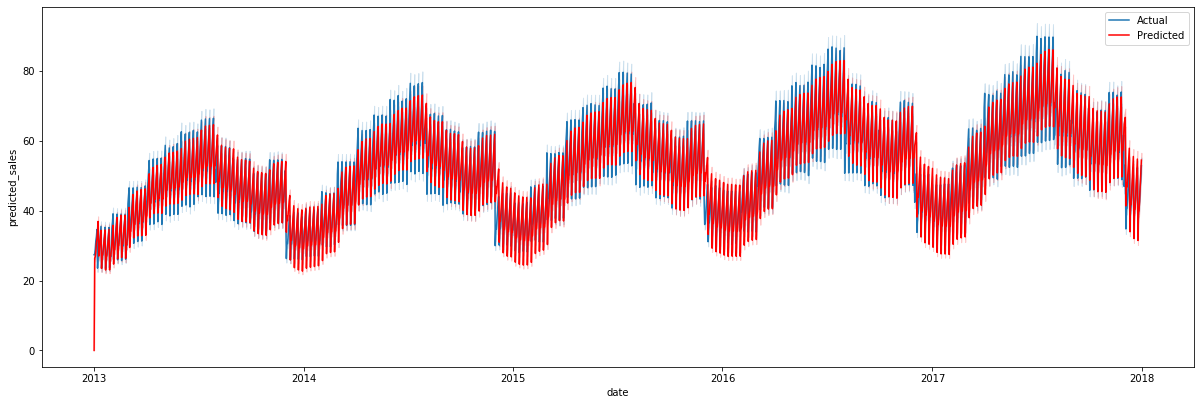

In [234]:
#Visualize original versus predicted values for training dataset
fig = plt.figure(figsize=(16,5))
ax = fig.add_axes([0,0,1,1])

sns.lineplot(x='date', y='actual_sales', 
             data=df_with_predictions[df_with_predictions['date'] < '2018-01-01'], 
             ax=ax, label='Actual'
            )

sns.lineplot(x='date', y='predicted_sales', 
             data=df_with_predictions[df_with_predictions['date'] < '2018-01-01'], 
             ax=ax, label='Predicted', color='red'
            );

In [240]:
#Set actual and predicted sales to use in SMAPE calculation 
y_actual = df_with_predictions[df_with_predictions['date'] < '2018-01-01']['actual_sales']
y_pred = df_with_predictions[df_with_predictions['date'] < '2018-01-01']['predicted_sales']

In [241]:
#Function to calculate smape for original versus predictions
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [242]:
#Calculate SMAPE
smape(y_actual, y_pred)

14.014676614729378

In [243]:
#Output predictions for first three months of 2018
predictions = df_with_predictions[df_with_predictions['date'] >= '2018-01-01']['predicted_sales']

In [244]:
len(predictions)

45000

In [245]:
save_path = Path('../data/time_series_SARIMAX_predictions.csv')

predictions.to_csv(save_path)

## Prophet

The procedure makes use of a decomposable time series model with three main model components: trend, seasonality, and holidays.

y(t) = g(t) + s(t) + h(t) + e(t)


g(t)
- trend models non-periodic changes; linear or logistic

s(t)
- seasonality represents periodic changes; i.e. weekly, monthly, yearly

h(t)
- ties in effects of holidays; on potentially irregular schedules ≥ 1 day(s)

The error term e(t) represents any idiosyncratic changes which are not accommodated by the model; later we will make the parametric assumption that e(t) is normally distributed.

In [ ]:
#Create dataframe for prophet model
prophet_df = train_df_final[['date', 'sales']]
#Set column names needed for prophet
#Column names for prophet compliance
prophet_df.columns = ['ds','y']

In [ ]:
prophet_df['ds']

In [ ]:
#Creat prophet object
prophet = Prophet()

In [ ]:
#Fit the model
prophet.fit(prophet_df)